## Variational Inference

The dataset required is small and is available preprocessed here:

- https://drive.google.com/drive/folders/1Tg_3SlKbdv0pDog6k2ys0J79e1-vgRyd?usp=sharing

In [1]:
import torch

from lafomo.datasets import P53Data
from lafomo.variational.kernels import RBF
from lafomo.variational.models import SingleLinearLFM
from lafomo.variational.trainer import P53ConstrainedTrainer
from lafomo.configuration import VariationalConfiguration
from lafomo.utilities.torch import save, load
from lafomo.plot import Plotter

from matplotlib import pyplot as plt

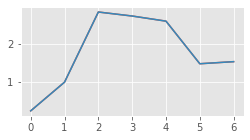

In [2]:
dataset = P53Data(replicate=0)
num_genes = 5
num_tfs = 1

t_inducing = torch.linspace(0, 12, 7, dtype=torch.float64)
t_observed = torch.linspace(0, 12, 7)
t_predict = torch.linspace(-1, 13, 80, dtype=torch.float64)

plt.figure(figsize=(4, 2))
plt.plot(dataset[0][1])
plt.plot(dataset.m_observed[0, 0])

In [4]:
options = VariationalConfiguration(
    preprocessing_variance=dataset.variance,
    learn_inducing=False,
    num_samples=50,
    kernel_scale=False
)
rtol = 1e-3
atol = rtol/10

model_kwargs = {
    'rtol': rtol, 'atol': atol
}
kernel = RBF(dataset.num_latents, scale=options.kernel_scale, dtype=torch.float64)
model = SingleLinearLFM(options, kernel, t_inducing, dataset)
optimizer = torch.optim.Adam(model.parameters(), lr=0.05)
trainer = P53ConstrainedTrainer(model, optimizer, dataset)
plotter = Plotter(model, dataset.gene_names)

/Users/jacob/Documents/proj/reggae/lafomo/variational/models/model.py:35: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.inducing_inputs = Parameter(torch.tensor(t_inducing), requires_grad=options.learn_inducing)
/Users/jacob/Documents/proj/reggae/lafomo/variational/models/model.py:51: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.initial_conditions = Parameter(torch.tensor(torch.zeros(self.num_outputs, 1)), requires_grad=True)


### Outputs prior to training:

/Users/jacob/Documents/proj/reggae/lafomo/plot/plotter.py:109: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  plt.subplot(plotnum)


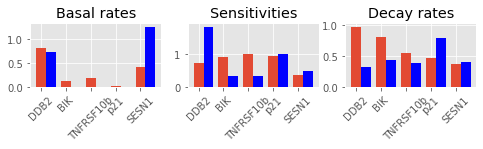

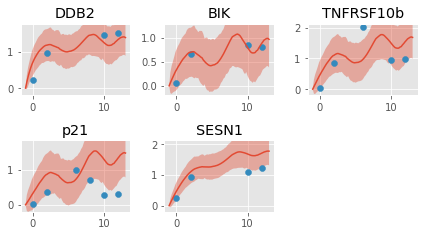

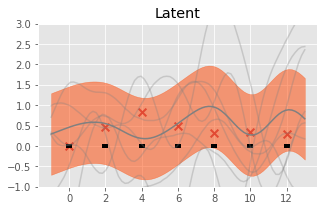

In [5]:
plotter.plot_kinetics()
plotter.plot_outputs(t_predict, replicate=0,
                     t_scatter=dataset.t_observed, y_scatter=dataset.m_observed,
                     model_kwargs=model_kwargs)
plotter.plot_latents(t_predict, ylim=(-1, 3), plot_barenco=True, plot_inducing=False)

In [ ]:
tol = 1e-4
import time
start = time.time()

output = trainer.train(20, rtol=tol, atol=tol/10,
                       report_interval=5, plot_interval=5)
end = time.time()
print(end - start)

### Outputs after training

In [ ]:
S = torch.tril(torch.stack(trainer.cholS).squeeze())
S = torch.matmul(S, S.transpose(1, 2))
plt.imshow(S[-1])

(-0.5, 99.5, 99.5, -0.5)

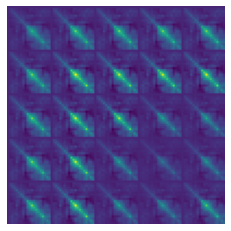

In [7]:
import numpy as np
timepoints = 20
t_temp = torch.linspace(0, 12, timepoints, dtype=torch.float64)
initial_value = torch.zeros((options.num_samples, 5, 1))
samples = model(t_temp, initial_value, return_samples=True, rtol=1e-3, atol=1e-3)
samples = samples.detach().numpy()
fig, ax = plt.subplots(nrows=1) #, figsize=(10, 10))
full_cov = np.zeros((timepoints*5, timepoints*5))
for j in range(5):
    x = samples[:, :, j].squeeze()
    covxx = np.cov(x)
    full_cov[j*timepoints:(j+1)*timepoints, j*timepoints:(j+1)*timepoints] = covxx

    for k in range(j+1, 5):
        y = samples[:,:, j+1].squeeze()
        covxy = np.cov(x, y)
        full_cov[j*timepoints:(j+1)*timepoints, k*timepoints:(k+1)*timepoints] = covxy[:timepoints, timepoints:]
        full_cov[k*timepoints:(k+1)*timepoints, j*timepoints:(j+1)*timepoints] = covxy[:timepoints, timepoints:]

ax.imshow(full_cov)
plt.axis('off')

In [8]:
mu = samples.mean(axis=1).reshape(-1)
mu = torch.tensor(mu, dtype=torch.float32)
cov = torch.tensor(full_cov, dtype=torch.float32) + torch.eye(5*timepoints) * 1e-1
print(mu.shape, cov.shape)
post_dist = torch.distributions.MultivariateNormal(mu, cov)
fig, ax = plt.subplots(nrows=num_genes, figsize=(5, 10))
for j in range(num_genes):
    ax[j].plot(mu.view(timepoints, num_genes)[:, j])
    for _ in range(10):
        sample = post_dist.sample().view(timepoints, num_genes)
        ax[j].plot(sample[:, j])

torch.Size([100]) torch.Size([100, 100])


ValueError: The parameter covariance_matrix has invalid values

/Users/jacob/Documents/proj/reggae/lafomo/plot/plotter.py:109: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  plt.subplot(plotnum)


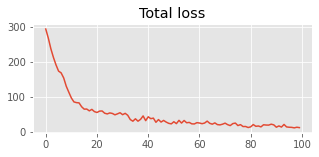

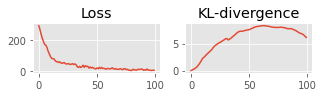

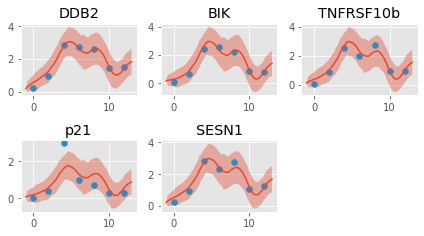

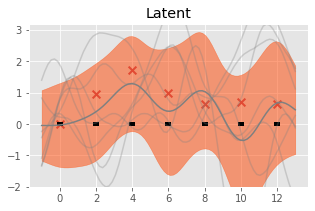

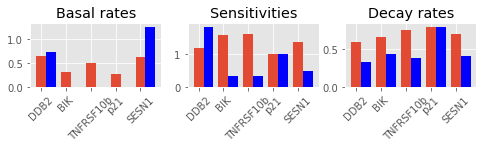

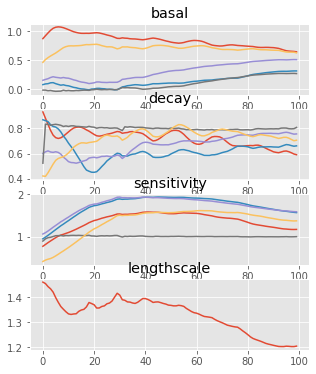

In [9]:
plotter.plot_losses(trainer, last_x=100)
plotter.plot_outputs(t_predict, replicate=0, ylim=(0, 3),
                     t_scatter=dataset.t_observed,
                     y_scatter=dataset.m_observed,
                     model_kwargs=model_kwargs)
plotter.plot_latents(t_predict, ylim=(-2, 3.2), plot_barenco=True, plot_inducing=False)
plotter.plot_kinetics()
plotter.plot_convergence(trainer)

In [ ]:
save(model, 'variational_linear')

In [ ]:
do_load = False
if do_load:
    model = load('variational_linear', SingleLinearLFM, num_genes, num_tfs,
                 t_inducing, dataset, extra_points=2, fixed_variance=dataset.variance)

    optimizer = torch.optim.Adam(model.parameters(), lr=0.1)
    trainer = P53ConstrainedTrainer(model, optimizer, dataset)
print(do_load)